# **Imports, Génération & Split des données**

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Paramètres, génération série synthétique
n = 60
t = np.arange(n)
beta0, beta1 = 100, 2
A, P = 20, 12
sigma = 5
trend = beta0 + beta1 * t
seasonality = A * np.sin(2 * np.pi * t / P)
noise = np.random.normal(0, sigma, n)
sales = trend + seasonality + noise
dates = pd.date_range(start="2020-01-01", periods=n, freq="M")
df = pd.Series(sales, index=dates)

# Split train/test
n_forecast = 12
df_train = df[:-n_forecast]
df_test = df[-n_forecast:]


/tmp/ipython-input-1062558838.py:18: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(start="2020-01-01", periods=n, freq="M")


# **Visualisation du split**

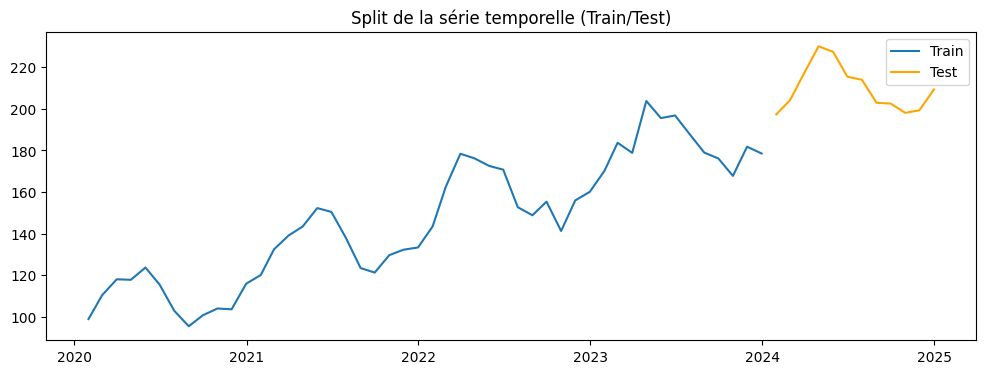

In [5]:
plt.figure(figsize=(12,4))
plt.plot(df_train, label="Train")
plt.plot(df_test, label="Test", color='orange')
plt.title("Split de la série temporelle (Train/Test)")
plt.legend()
plt.show()


On observe la partie entraînement (bleu), la partie test (orange).

# **Stationnarité & diagnostiques sur train uniquement**

In [6]:
def adf_test(series, title=''):
    result = adfuller(series)
    print(f'=== Test ADF - {title} ===')
    print(f'Statistique ADF: {result[0]:.4f}, p-value: {result[1]:.4f}')
    print('Valeurs critiques:', result[4])
    print('=>', 'Stationnaire' if result[1]<0.05 else 'Non-stationnaire')

adf_test(df_train, "Train (Original)")
df_train_diff1 = df_train.diff().dropna()
adf_test(df_train_diff1, "Train (Différence simple)")
df_train_diff2 = df_train_diff1.diff(P).dropna()
adf_test(df_train_diff2, "Train (Double différenciation)")


=== Test ADF - Train (Original) ===
Statistique ADF: -0.5450, p-value: 0.8829
Valeurs critiques: {'1%': np.float64(-3.6209175221605827), '5%': np.float64(-2.9435394610388332), '10%': np.float64(-2.6104002410518627)}
=> Non-stationnaire
=== Test ADF - Train (Différence simple) ===
Statistique ADF: -5.5933, p-value: 0.0000
Valeurs critiques: {'1%': np.float64(-3.6209175221605827), '5%': np.float64(-2.9435394610388332), '10%': np.float64(-2.6104002410518627)}
=> Stationnaire
=== Test ADF - Train (Double différenciation) ===
Statistique ADF: -0.7329, p-value: 0.8380
Valeurs critiques: {'1%': np.float64(-3.7377092158564813), '5%': np.float64(-2.9922162731481485), '10%': np.float64(-2.635746736111111)}
=> Non-stationnaire


Les tests ADF (sur train) indiquent la stationnarité ou non à chaque transformation.

# **Visualisation ACF/PACF sur train doublement différencié**

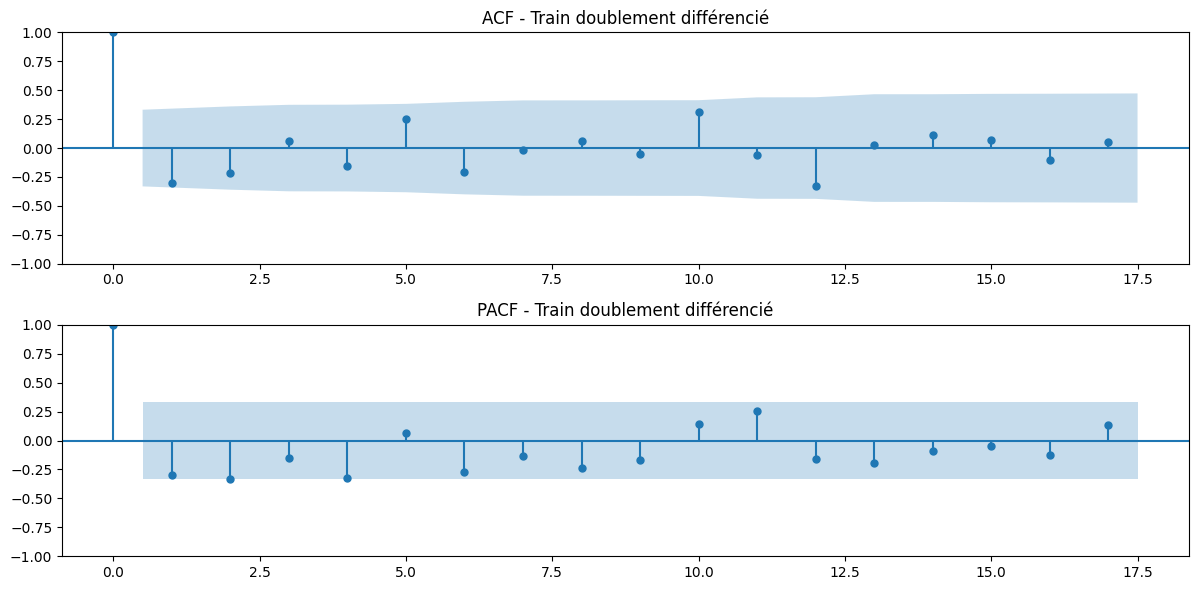

In [7]:
max_lags = len(df_train_diff2)//2
fig, axes = plt.subplots(2, 1, figsize=(12, 6))
plot_acf(df_train_diff2, lags=max_lags, ax=axes[0], title="ACF - Train doublement différencié")
plot_pacf(df_train_diff2, lags=max_lags, ax=axes[1], title="PACF - Train doublement différencié")
plt.tight_layout()
plt.show()


Ces graphes aident à choisir l'ordre des modèles AR, MA, SARIMA.

# **Entraînement du modèle SARIMA sur train**

In [8]:
model = SARIMAX(df_train, order=(1,1,1), seasonal_order=(1,1,1,P), enforce_stationarity=False, enforce_invertibility=False)
sarima_result = model.fit(disp=False)
print(sarima_result.summary())


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                   48
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 -67.573
Date:                            Mon, 27 Oct 2025   AIC                            145.146
Time:                                    16:54:59   BIC                            150.369
Sample:                                01-31-2020   HQIC                           146.280
                                     - 12-31-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2712      0.338     -0.803      0.422      -0.933       0.391
ma.L1         -0.8399      0.211   

On ajuste un modèle SARIMA aux paramètres observés (1,1,1)x(1,1,1,12).
La table du résumé donne :

Les valeurs estimées des coefficients du modèle (AR, MA, saisonniers…)

Des critères d’adéquation (AIC, BIC…), servant à comparer différents modèles

Les erreurs associées, indiquant si les coefficients sont significatifs.

# **Prédiction sur la période de test**

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


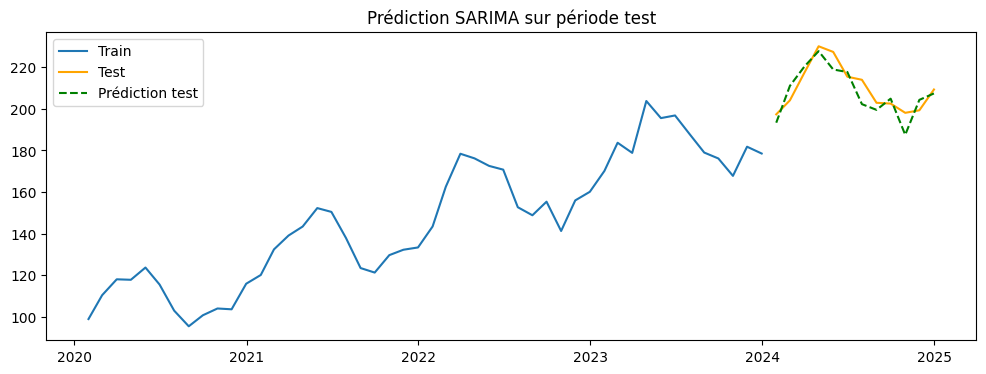

In [9]:
pred_test = sarima_result.predict(start=df_test.index[0], end=df_test.index[-1], typ="levels")
plt.figure(figsize=(12,4))
plt.plot(df_train, label="Train")
plt.plot(df_test, label="Test", color='orange')
plt.plot(pred_test, label="Prédiction test", color='green', linestyle='--')
plt.title("Prédiction SARIMA sur période test")
plt.legend()
plt.show()




La courbe verte en pointillé représente ce que le modèle prédit sur la période test (jamais vue pendant l’entraînement).

Si les prédictions suivent bien la courbe orange, le modèle généralise correctement et capte la tendance/saisonnalité sur de nouvelles données.

Si elles s’écartent, le modèle doit être réajusté ou complexifié.

# **Prévision sur 12 mois futurs**

/tmp/ipython-input-945478896.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=df.index[-1] + pd.offsets.MonthEnd(), periods=12, freq="M")


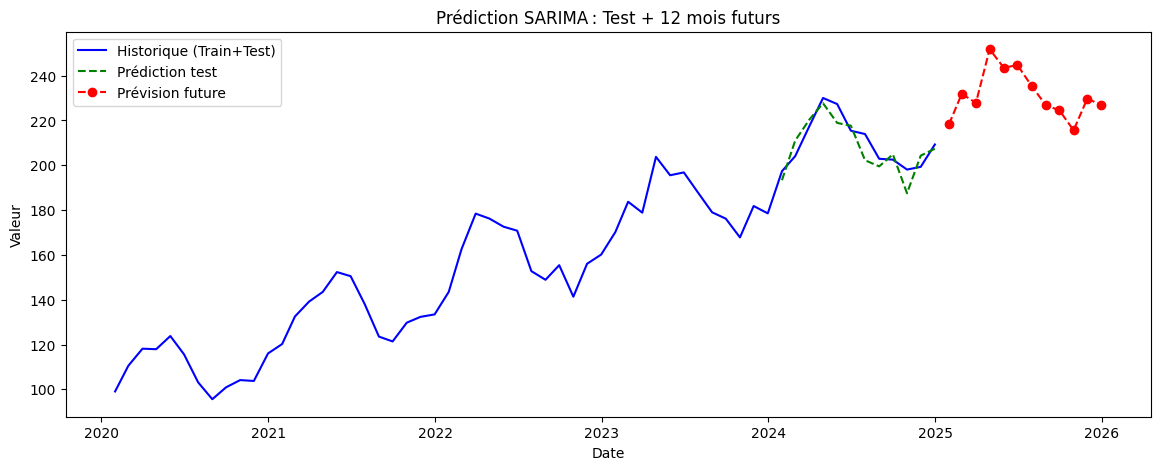

In [10]:
future_dates = pd.date_range(start=df.index[-1] + pd.offsets.MonthEnd(), periods=12, freq="M")
pred_future = sarima_result.predict(start=future_dates[0], end=future_dates[-1], typ="levels")

plt.figure(figsize=(14,5))
plt.plot(df, label="Historique (Train+Test)", color='blue')
plt.plot(pred_test, label="Prédiction test", color='green', linestyle='--')
plt.plot(future_dates, pred_future, marker='o', linestyle='--', color='red', label="Prévision future")
plt.xlabel("Date"); plt.ylabel("Valeur")
plt.title("Prédiction SARIMA : Test + 12 mois futurs")
plt.legend()
plt.show()


La ligne rouge en pointillé projette la série sur l’année à venir.

Cela permet de simuler comment l’entreprise/le système évoluerait s’il reste sur le même schéma : croissance, saisonnalité, bruit conservés.

Plus on se projette loin dans le futur, plus l’incertitude de la prévision augmente.

# **Diagnostic sur les résidus (Entraînement uniquement)**

=== Test ADF - Résidus du train SARIMA ===
Statistique ADF: -5.9253, p-value: 0.0000
Valeurs critiques: {'1%': np.float64(-3.584828853223594), '5%': np.float64(-2.9282991495198907), '10%': np.float64(-2.6023438271604937)}
=> Stationnaire


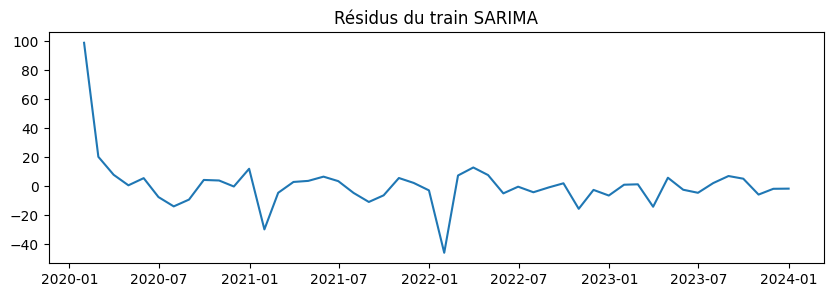

In [11]:
residuals_train = df_train - sarima_result.fittedvalues
adf_test(residuals_train.dropna(), "Résidus du train SARIMA")
plt.figure(figsize=(10,3))
plt.plot(residuals_train)
plt.title("Résidus du train SARIMA")
plt.show()


Les résidus stationnaires et dispersés valident le modèle. DIAGNOSTIC UNIQUEMENT SUR TRAIN, JAMAIS SUR TEST !

# **Modèle ARMA (sur série stationnaire)**

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   35
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -120.278
Date:                Mon, 27 Oct 2025   AIC                            248.556
Time:                        17:37:24   BIC                            254.777
Sample:                    02-28-2021   HQIC                           250.704
                         - 12-31-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0881      0.196     -0.450      0.653      -0.472       0.296
ar.L1          0.1856      0.265      0.700      0.484      -0.334       0.705
ma.L1         -0.9998     67.247     -0.015      0.9

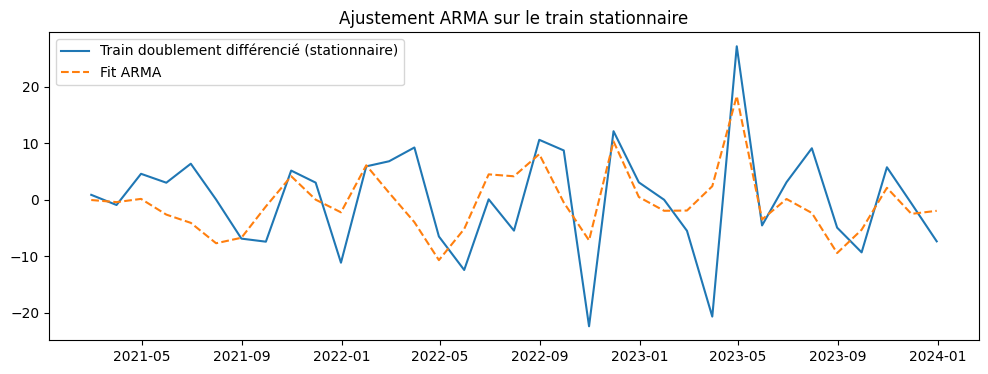

In [12]:
from statsmodels.tsa.arima.model import ARIMA

# Série stationnaire (doublement différenciée sur le train)
stationary_train = df_train.diff().dropna().diff(P).dropna()

# Ajustement ARMA(p,q) — ici p=1, q=1
arma_model = ARIMA(stationary_train, order=(1,0,1))
arma_result = arma_model.fit()
print(arma_result.summary())

# Visualisation fit ARMA sur le train stationnaire
plt.figure(figsize=(12,4))
plt.plot(stationary_train, label="Train doublement différencié (stationnaire)")
plt.plot(arma_result.fittedvalues, label="Fit ARMA", linestyle='--')
plt.title("Ajustement ARMA sur le train stationnaire")
plt.legend()
plt.show()


Un bon fit signifie que le modèle ARMA capte bien la structure des résidus de la série transformée. Les diagnostics sont à interpréter avec précaution.

# **Prévision ARMA sur la partie test**

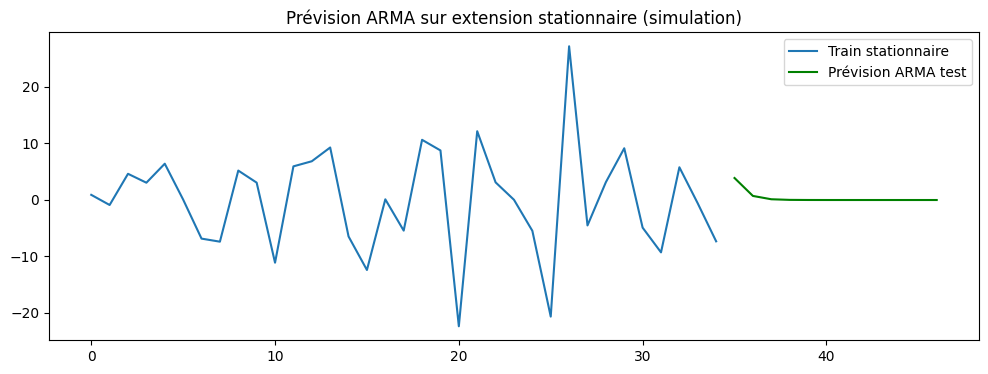

In [13]:
# Prévision/simulation ARMA sur les 12 points suivants (option de base)
forecast_arma = arma_result.forecast(steps=n_forecast)
plt.figure(figsize=(12,4))
plt.plot(np.arange(len(stationary_train)), stationary_train, label="Train stationnaire")
plt.plot(np.arange(len(stationary_train), len(stationary_train)+n_forecast), forecast_arma, label="Prévision ARMA test", color='green')
plt.title("Prévision ARMA sur extension stationnaire (simulation)")
plt.legend()
plt.show()


Prévision purement sur la structure ARMA stationnaire.

# **Modèle ARIMA (sur train complet, inclut différenciation)**

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   48
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -172.639
Date:                Mon, 27 Oct 2025   AIC                            351.277
Time:                        17:43:55   BIC                            356.828
Sample:                    01-31-2020   HQIC                           353.366
                         - 12-31-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4767      0.706      0.675      0.500      -0.907       1.860
ma.L1         -0.2955      0.763     -0.387      0.698      -1.791       1.200
sigma2        90.6943     24.359      3.723      0.0

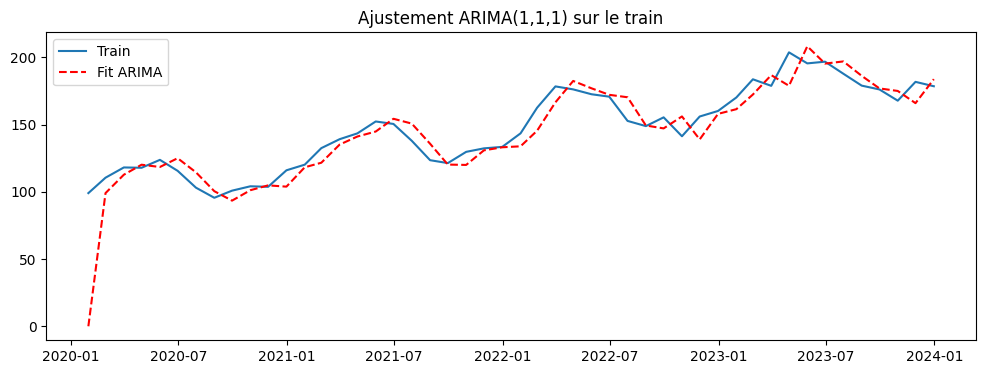

In [14]:
# Ajustement ARIMA (p,d,q) sur série train brute
arima_model = ARIMA(df_train, order=(1,1,1)) # 1 diff simple (d=1)
arima_result = arima_model.fit()
print(arima_result.summary())

# Visualisation fit ARIMA sur le train
plt.figure(figsize=(12,4))
plt.plot(df_train, label="Train")
plt.plot(arima_result.fittedvalues, label="Fit ARIMA", linestyle='--', color='red')
plt.title("Ajustement ARIMA(1,1,1) sur le train")
plt.legend()
plt.show()


ARIMA gère le non-stationnarité par différenciation interne et ajuste la série brute.

# **Prédiction ARIMA sur la période test**

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


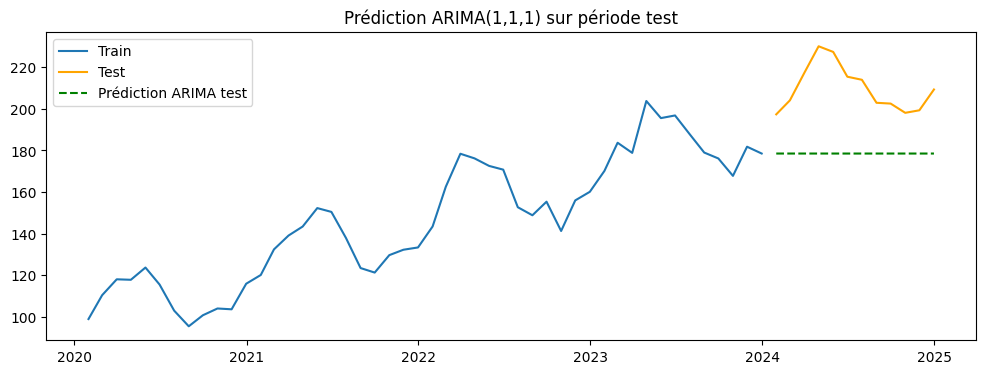

ARIMA(1,1,1) - Performance sur test : MAE=31.27 | RMSE=33.04


In [18]:
# Prédiction sur la période test
pred_arima_test = arima_result.predict(start=df_test.index[0], end=df_test.index[-1], typ="levels")
from sklearn.metrics import mean_absolute_error, mean_squared_error

plt.figure(figsize=(12,4))
plt.plot(df_train, label="Train")
plt.plot(df_test, label="Test", color='orange')
plt.plot(pred_arima_test, label="Prédiction ARIMA test", color='green', linestyle='--')
plt.title("Prédiction ARIMA(1,1,1) sur période test")
plt.legend()
plt.show()

# Score de performance
mae_arima = mean_absolute_error(df_test, pred_arima_test)
rmse_arima = np.sqrt(mean_squared_error(df_test, pred_arima_test))
print(f"ARIMA(1,1,1) - Performance sur test : MAE={mae_arima:.2f} | RMSE={rmse_arima:.2f}")


Un bon modèle ARIMA donne des scores de validation comparables ou meilleurs que SARIMA quand la saisonnalité n’est pas dominante. On visualise la performance prédictive facilement.

# ** Prévision ARIMA sur 12 mois futurs**

/tmp/ipython-input-1199244320.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=df.index[-1] + pd.offsets.MonthEnd(), periods=12, freq="M")
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


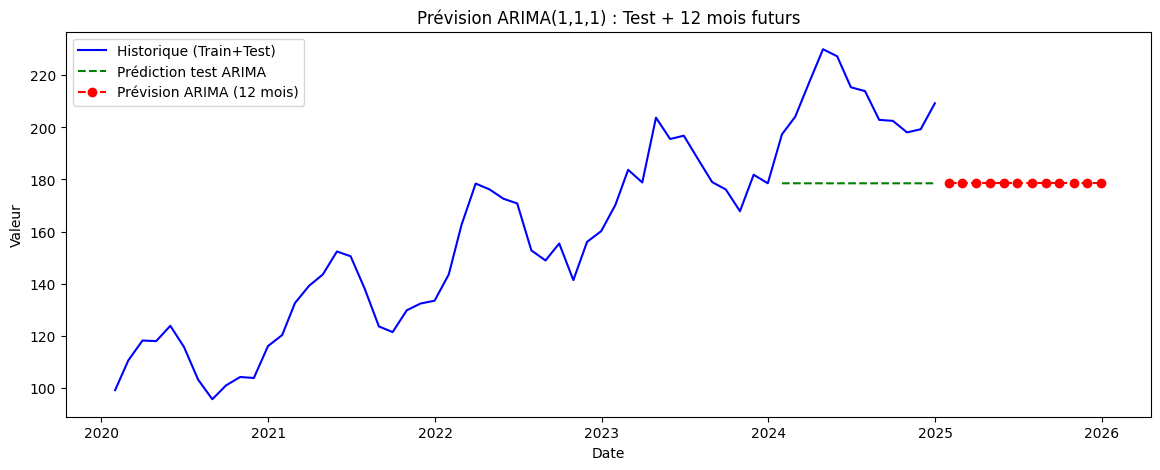

In [19]:
future_dates = pd.date_range(start=df.index[-1] + pd.offsets.MonthEnd(), periods=12, freq="M")
pred_arima_future = arima_result.predict(start=future_dates[0], end=future_dates[-1], typ="levels")

plt.figure(figsize=(14,5))
plt.plot(df, label="Historique (Train+Test)", color='blue')
plt.plot(pred_arima_test, label="Prédiction test ARIMA", color='green', linestyle='--')
plt.plot(future_dates, pred_arima_future, marker='o', linestyle='--', color='red', label="Prévision ARIMA (12 mois)")
plt.xlabel("Date"); plt.ylabel("Valeur")
plt.title("Prévision ARIMA(1,1,1) : Test + 12 mois futurs")
plt.legend()
plt.show()


On extrapole vers l’avenir, ce qui permet la comparaison avec SARIMA sur la capacité prédictive long-terme.